# Chest X-Ray CNN Image Classification Project

## Part 1: Problem Description

This project aims to detect Pneumonia in patients by analyzing Chest X-Ray images with the help of Convolutional Neural Networks. It utilizes the third version of a specific dataset that contains two primary folders for training and test purposes.

For the image classification task, I have chosen three approaches: employing a basic CNN then making that CNN more complex and finally implementing histogram equalized images on the final model.

The dataset used in this project is the Chest X-Ray dataset, available at: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images

## Part 2: Data Description and Information

This dataset has 5,856 authenticated Chest X-Ray images, divided between a training set and a testing set, featuring images from distinct patients. Each image is categorized with labels indicating the condition (NORMAL/BACTERIA/VIRUS), followed by a randomized patient ID and the patient's image number.

The paper details that these images (taken from an anterior-posterior perspective) were chosen from retrospective groups of pediatric patients aged between one and five years from the Guangzhou Women and Children’s Medical Center in Guangzhou.

### Importing Some Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd       
import numpy as np

# Operating system interaction
import os

# Visualization libraries
import matplotlib.pyplot as plt    
import seaborn as sns
%matplotlib inline
import math

# Machine learning and image processing libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import glob
import cv2

# Set seeds for reproducibility
from numpy.random import seed
seed(42)
import random
random.seed(42)
from tensorflow.random import set_seed
set_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# TensorFlow modules
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks



# Set display option for pandas
pd.options.display.max_colwidth = 100

# Suppress specific warnings or review if general suppression is needed
import warnings
warnings.filterwarnings('ignore')


Now, we set three key parameters for our machine learning tasks. The choice of these parameters was made based on standards.

1. IMG_SIZE = 224: Sets both height and width of the images to 224 pixels, standardizing their size for uniform processing by Convolutional Neural Networks, as CNNs require fixed input dimensions.

2. BATCH = 32: Establishes the batch size as 32, meaning the model processes 32 images in each training iteration. This number balances computational efficiency and effective learning.

3. SEED = 42: Assigns a seed value of 42 for random number generation, ensuring consistent and reproducible results in operations like data shuffling or weight initialization in neural networks.

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
## Loading the data
main_path = "chest_xray"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

Now, we create dataframes for the training and testing data where we label each record as Normal or Pneumonia.

In [4]:
# Training Data
train_list = train_normal + train_pneumonia
train_labels = ['Normal'] * len(train_normal) + ['Pneumonia'] * len(train_pneumonia)
df_train = pd.DataFrame(zip(train_labels, train_list), columns=['class', 'image'])

# Testing Data
test_list = test_normal + test_pneumonia
test_labels = ['Normal'] * len(test_normal) + ['Pneumonia'] * len(test_pneumonia)
df_test = pd.DataFrame(zip(test_labels, test_list), columns=['class', 'image'])


In [5]:
def pretty_print(df, title, num_rows=10):
    # Printing the title
    print(f"--- {title} ---")
    print(f"Total rows: {len(df)}")
    
    # Formatting column headers
    headers = " | ".join([f"{col:15}" for col in df.columns])
    print(headers)
    print("-" * len(headers))

    # Printing a limited number of rows
    for idx, row in enumerate(df.head(num_rows).itertuples(), 1):
        row_str = " | ".join([f"{str(row[i+1]):15}" for i, col in enumerate(df.columns)])
        print(row_str)

    # Indicate if there are more rows
    if len(df) > num_rows:
        print(f"... (and {len(df) - num_rows} more rows)")

# Using the custom function to print DataFrames
pretty_print(df_train, "Training Data")
pretty_print(df_test, "Testing Data")


--- Training Data ---
Total rows: 5232
class           | image          
---------------------------------
Normal          | chest_xray/train/NORMAL/NORMAL-2552119-0002.jpeg
Normal          | chest_xray/train/NORMAL/NORMAL-7298141-0001.jpeg
Normal          | chest_xray/train/NORMAL/NORMAL-3411116-0002.jpeg
Normal          | chest_xray/train/NORMAL/NORMAL-1619233-0001.jpeg
Normal          | chest_xray/train/NORMAL/NORMAL-7327513-0001.jpeg
Normal          | chest_xray/train/NORMAL/NORMAL-2699389-0001.jpeg
Normal          | chest_xray/train/NORMAL/NORMAL-3781678-0001.jpeg
Normal          | chest_xray/train/NORMAL/NORMAL-8648239-0002.jpeg
Normal          | chest_xray/train/NORMAL/NORMAL-5728847-0001.jpeg
Normal          | chest_xray/train/NORMAL/NORMAL-6881695-0001.jpeg
... (and 5222 more rows)
--- Testing Data ---
Total rows: 624
class           | image          
---------------------------------
Normal          | chest_xray/test/NORMAL/NORMAL-8698006-0001.jpeg
Normal          | chest_xra

## Part 3: EDA

Having loaded the data and assembled our dataframe, we will now proceed with exploratory analysis. This will involve utilizing various plots and graphs to gain insights into the data, accompanied by displaying a selection of the images.

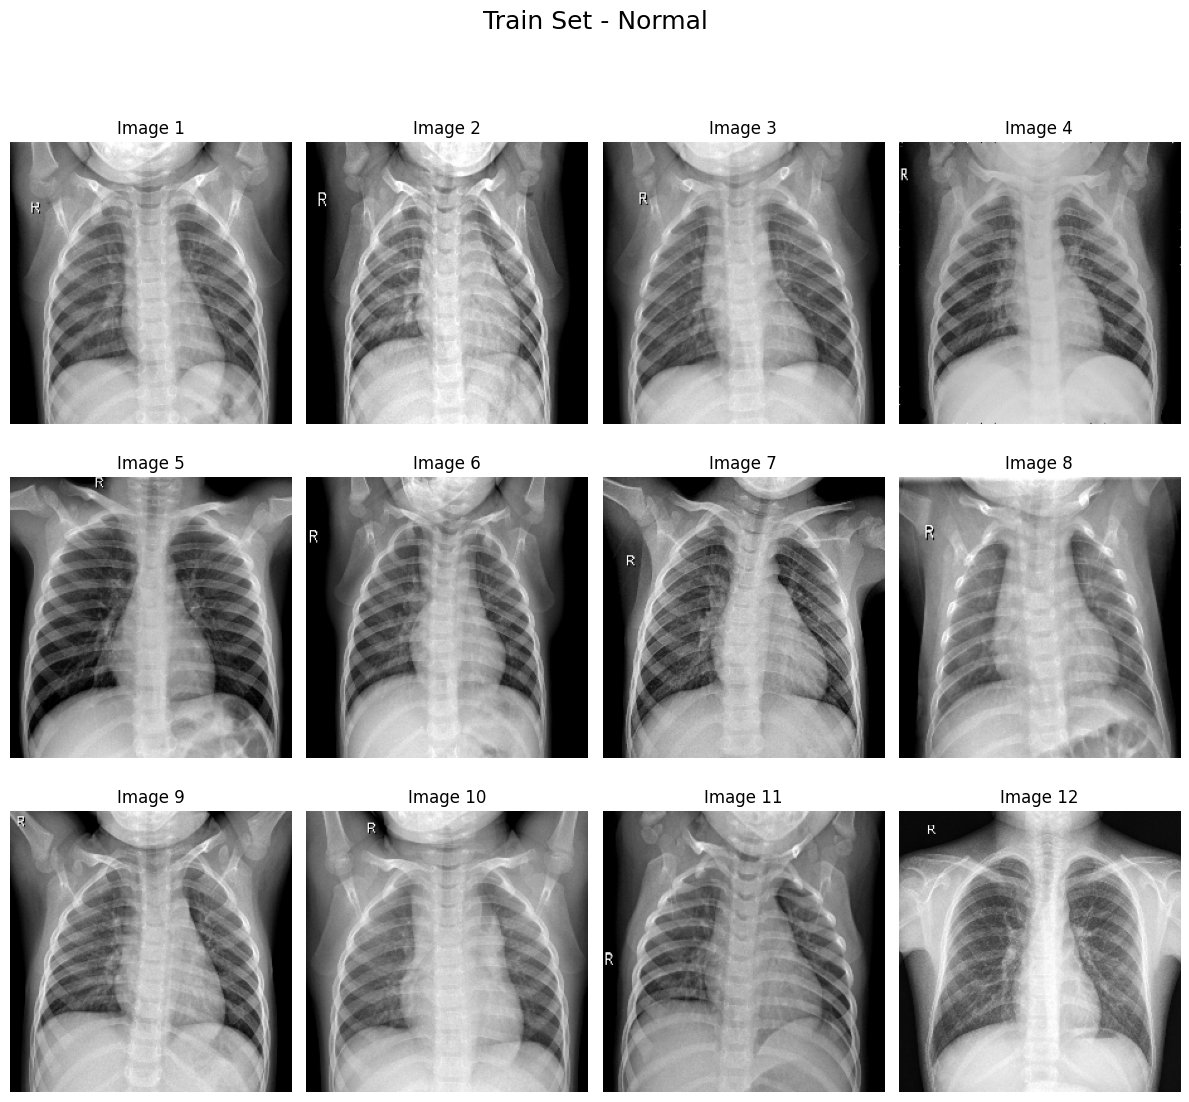

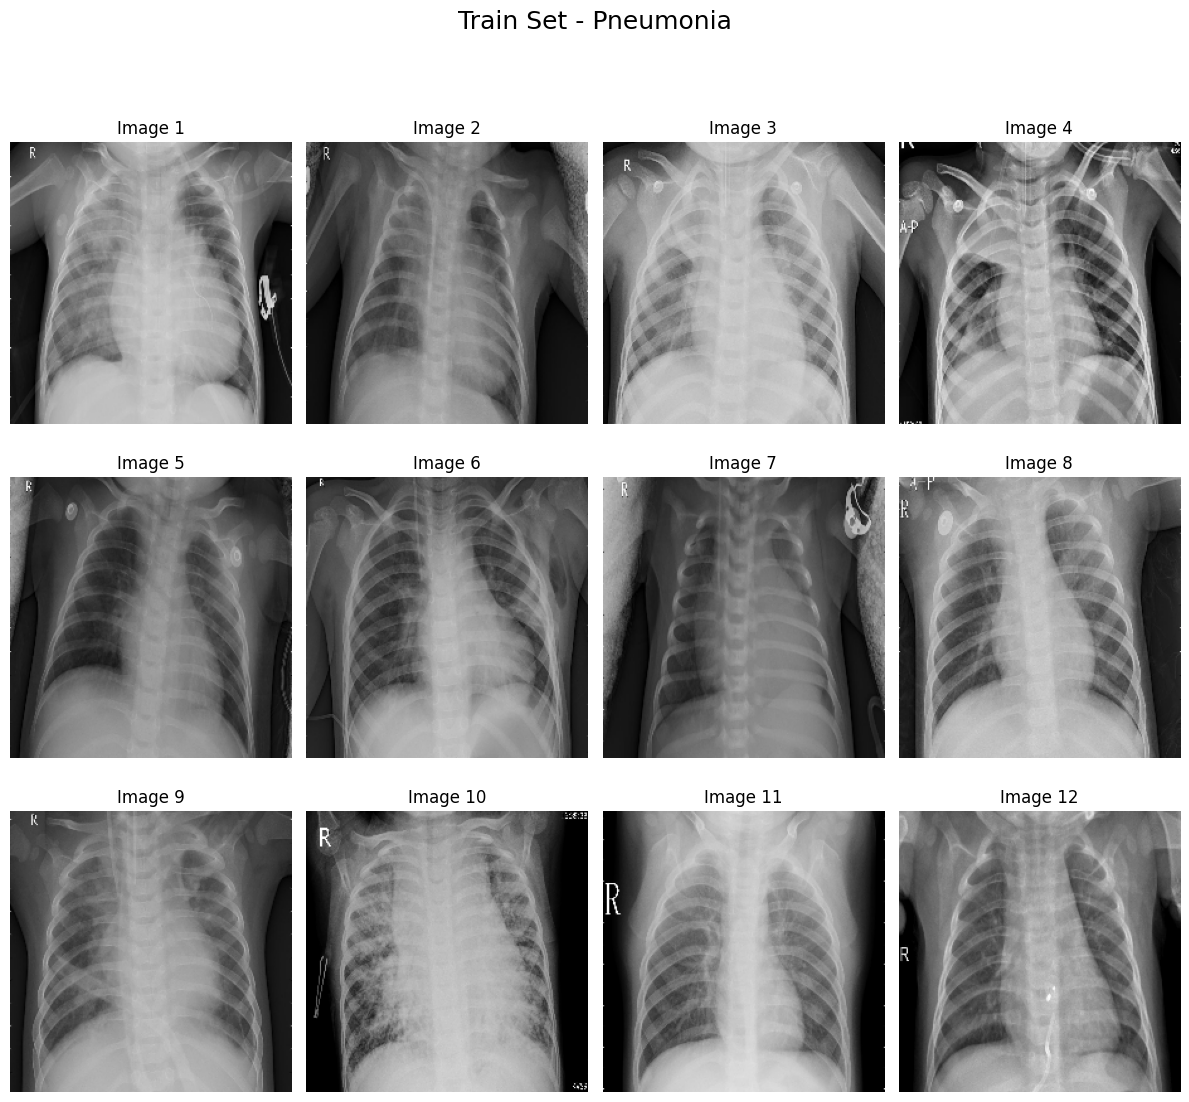

In [6]:
import matplotlib.pyplot as plt
import cv2

def show_images(image_paths, title):
    plt.figure(figsize=(12,12))
    plt.suptitle(title, fontsize=18)

    for i, image_path in enumerate(image_paths[:12]):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the subplots to fit the figure area.
    plt.show()

# Display Normal Training Set Images
show_images(train_normal, 'Train Set - Normal')

# Display Pneumonia Training Set Images
show_images(train_pneumonia, 'Train Set - Pneumonia')


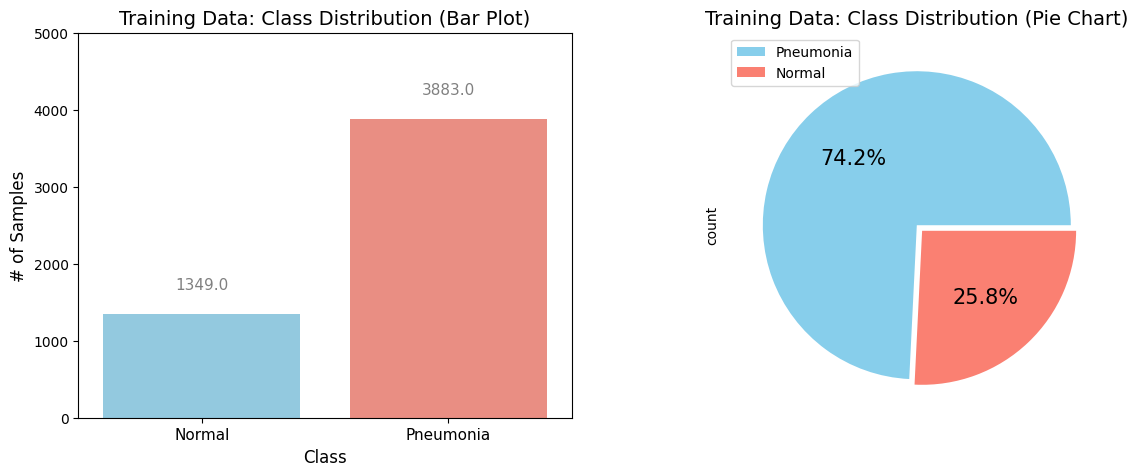

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the figure for the subplots
plt.figure(figsize=(14, 5))

# Colors for consistency
colors = ['skyblue', 'salmon']

# Bar Plot for Training Data
plt.subplot(1, 2, 1)
ax = sns.countplot(x='class', data=df_train, palette=colors)
plt.xlabel("Class", fontsize=12)
plt.ylabel("# of Samples", fontsize=12)
plt.ylim(0, 5000)
plt.xticks([0, 1], ['Normal', 'Pneumonia'], fontsize=11)
plt.title("Training Data: Class Distribution (Bar Plot)", fontsize=14)
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height() + 200), 
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')

# Pie Chart for Training Data
plt.subplot(1, 2, 2) 
df_train['class'].value_counts().plot(kind='pie', labels=['', ''], autopct='%1.1f%%', colors=colors, explode=[0, 0.05], textprops={"fontsize":15})
plt.title("Training Data: Class Distribution (Pie Chart)", fontsize=14)
plt.legend(labels=['Pneumonia', 'Normal'])

# Show the plots
plt.show()


There is a significant imbalance with a greater number of Pneumonia cases compared to Normal cases. This is also reflected in the pie chart where Pneumonia cases account for 74.3% of the data, leaving Normal cases at 25.7%.
The imbalance could potentially help the model become better at identifying pneumonia features but possibly at the expense of being less sensitive to Normal X-rays.

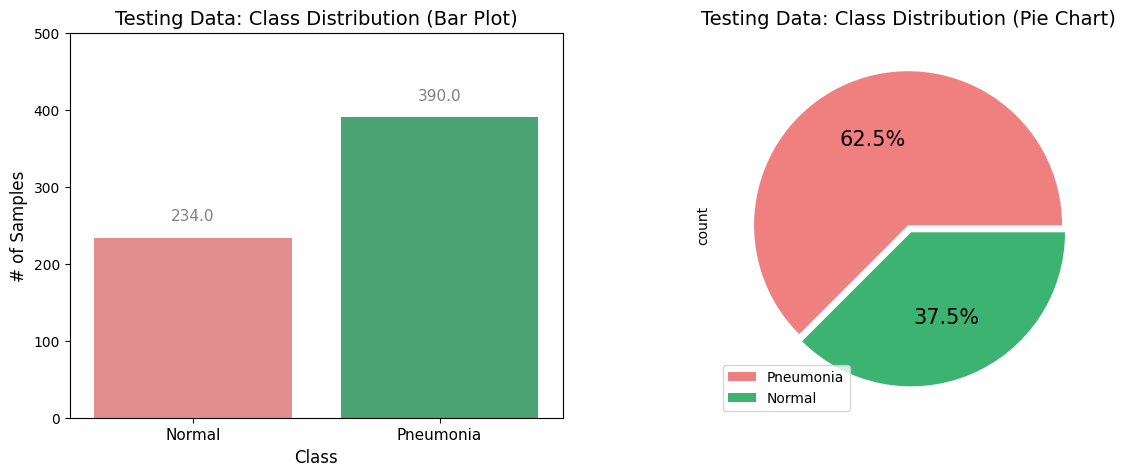

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the figure for the subplots
plt.figure(figsize=(14, 5))

# Colors for consistency in testing data plots
colors = ['lightcoral', 'mediumseagreen']

# Bar Plot for Testing Data
plt.subplot(1, 2, 1) 
ax = sns.countplot(x='class', data=df_test, palette=colors)
plt.xlabel("Class", fontsize=12)
plt.ylabel("# of Samples", fontsize=12)
plt.ylim(0, 500)
plt.xticks([0, 1], ['Normal', 'Pneumonia'], fontsize=11)
plt.title("Testing Data: Class Distribution (Bar Plot)", fontsize=14)
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height() + 10), 
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')

# Pie Chart for Testing Data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
df_test['class'].value_counts().plot(kind='pie', labels=['', ''], autopct='%1.1f%%', colors=colors, explode=[0, 0.05], textprops={"fontsize":15})
plt.title("Testing Data: Class Distribution (Pie Chart)", fontsize=14)
plt.legend(labels=['Pneumonia', 'Normal'])

# Show the plots
plt.show()


The bar plot indicates a better balance compared to the training data. However, Pneumonia still represents a majority, as we can see in the pie chart with 62.5% of the data, while Normal accounts for 37.5%.
The more balanced distribution can lead to a more rigorous test of the model's ability to generalize, but the continued prevalence of Pneumonia cases could still introduce bias.

In practice, this could result in a model with high sensitivity (true positive rate) for detecting Pneumonia but potentially lower specificity (true negative rate) for identifying Normal cases. We will attempt to mitigate these imbalances using different techniques moving forward.


We're going to assess the impact of increased image contrast on feature visibility. This will be done by applying histogram equalization, and we'll start by comparing how images look before and after this enhancement. The sample comparison below demonstrates that histogram equalization can improve the ability to identify certain elements within the chest X-rays by increasing the contrast. This is especially important for medical imaging where the definition of lung tissue and boundary lines is crucial, such as in detecting pneumonia, and could offer significant advantages.

Regarding our model, we will initially train it using non equalized images. After that, we will train it again on images processed with histogram equalization. The performance in each case will guide our decision on whether to integrate this technique into our processing pipeline.

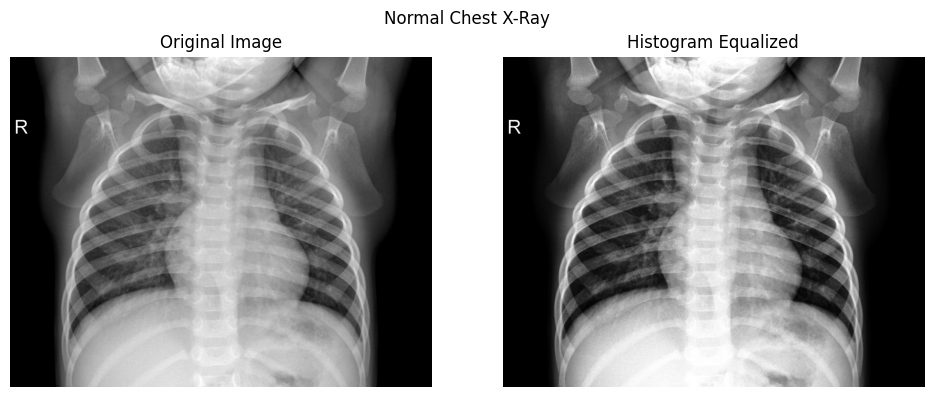

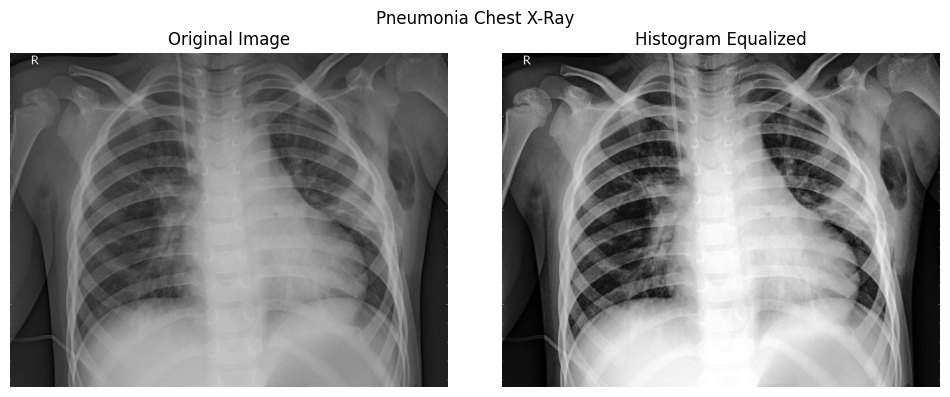

In [9]:
import cv2
import matplotlib.pyplot as plt

def plot_histogram_equalization(image_path, title):
    img = cv2.imread(image_path, 0)
    img_eq = cv2.equalizeHist(img)
    
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_eq, cmap='gray')
    plt.title('Histogram Equalized')
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Apply and plot histogram equalization on a normal and a pneumonia image
plot_histogram_equalization(train_normal[5], 'Normal Chest X-Ray')
plot_histogram_equalization(train_pneumonia[5], 'Pneumonia Chest X-Ray')


## Step 4: Preparing the data for the model

To start, we're setting up a validation set. We will take our starting batch of training data and split it: 80% stays to train the model, and the other 20% steps back to be our test ground. We make sure that the split keeps the same mix of 'Normal' and 'Pneumonia' cases as the full set, so the training and validation sets are mini versions of the whole data.


In [10]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

Next, we'll proceed to load and preprocess the images, preparing them for model input.

We initiate this process by establishing data generators utilizing Keras's ImageDataGenerator. This tool allows us to normalize pixel values and execute an assortment of real-time data augmentation techniques. Two distinct generators are configured for this purpose: one for validation, val_datagen, which solely normalizes the data, and another for training, train_datagen, which also incorporates various augmentation methods to enhance the dataset.

These generators are then applied to their respective datasets via the flow_from_dataframe function. In this step, images are not only transformed according to the specifications of each generator but are also resized to a predetermined target size.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image normalization and augmentation configuration for the training set
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.1,
    rotation_range=10, 
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Image normalization for the validation and testing sets
val_datagen = ImageDataGenerator(rescale=1/255.)

# Generating the training, validation, and testing sets
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size=BATCH,
    seed=SEED
)

ds_val = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size=BATCH,
    seed=SEED
)

ds_test = val_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size=1,  # Typically, we use a batch size of 1 for testing to process one image at a time
    shuffle=False  # It's important not to shuffle the test set if we're going to evaluate the model later
)


Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


### Setting up histogram equalized images


In [28]:
import os
import cv2

def preprocess_and_save_image(input_path, output_path):
    try:
        # Read the image in grayscale
        img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

        # Apply histogram equalization
        img_eq = cv2.equalizeHist(img)

        # Save the processed image
        cv2.imwrite(output_path, img_eq)
    except Exception as e:
        print(f"An error occurred while processing {input_path}: {e}")

def process_directory(input_dir, output_dir):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process each file or directory in the input directory
    for filename in os.listdir(input_dir):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        if os.path.isfile(input_path):
            preprocess_and_save_image(input_path, output_path)
        elif os.path.isdir(input_path):
            # Recurse into subdirectories
            new_input_dir = input_path
            new_output_dir = os.path.join(output_dir, filename)
            process_directory(new_input_dir, new_output_dir)

# Define the base input and output directories
base_input_directory = 'chest_xray'
base_output_directory = 'chest_xray_he'

process_directory(base_input_directory, base_output_directory) ## activate this to pre process images agin


An error occurred while processing chest_xray/.DS_Store: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

An error occurred while processing chest_xray/test/.DS_Store: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



In [29]:
# Define paths to preprocessed data
main_path_he = "chest_xray_he"
train_path_he = os.path.join(main_path_he, "train")
test_path_he = os.path.join(main_path_he, "test")

# Get list of paths for normal and pneumonia images
train_normal_he = glob.glob(os.path.join(train_path_he, "normal", "*.jpeg"))
train_pneumonia_he = glob.glob(os.path.join(train_path_he, "pneumonia", "*.jpeg"))

test_normal_he = glob.glob(os.path.join(test_path_he, "normal", "*.jpeg"))
test_pneumonia_he = glob.glob(os.path.join(test_path_he, "pneumonia", "*.jpeg"))

# Create dataframes
train_list_he = train_normal_he + train_pneumonia_he
train_labels_he = ['Normal'] * len(train_normal_he) + ['Pneumonia'] * len(train_pneumonia_he)
df_train_he = pd.DataFrame(zip(train_labels_he, train_list_he), columns=['class', 'image'])

test_list_he = test_normal_he + test_pneumonia_he
test_labels_he = ['Normal'] * len(test_normal_he) + ['Pneumonia'] * len(test_pneumonia_he)
df_test_he = pd.DataFrame(zip(test_labels_he, test_list_he), columns=['class', 'image'])

# Split training data into training and validation sets
train_df_he, val_df_he = train_test_split(df_train_he, test_size=0.20, random_state=SEED, stratify=df_train_he['class'])

# Image normalization and augmentation configuration for the training set
train_datagen_he = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.1,
    rotation_range=10, 
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Image normalization for the validation and testing sets
val_datagen_he = ImageDataGenerator(rescale=1/255.)

# Generating the training, validation, and testing sets
ds_train_he = train_datagen_he.flow_from_dataframe(
    dataframe=train_df_he,
    x_col='image',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size=BATCH,
    seed=SEED
)

ds_val_he = val_datagen_he.flow_from_dataframe(
    dataframe=val_df_he,
    x_col='image',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size=BATCH,
    seed=SEED
)

ds_test_he = val_datagen_he.flow_from_dataframe(
    dataframe=df_test_he,
    x_col='image',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size=1,  
    shuffle=False 
)


Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


## Step 5: Model architecture and training

### Architecture

### Model 1:
Our models are designed to efficiently process images and perform binary classification tasks. This first model is a simple two block model with a few layers. It begins with convolutional layers that gradually increase in complexity, allowing the model to extract features ranging from simple edges to more intricate patterns. These features are enhanced through ReLU activation, introducing crucial non linearity to capture complex data patterns effectively. To prevent overfitting, we incorporate dropout layers that randomly deactivate neurons during training, fostering model generalization by preventing reliance on specific pathways. Additionally, batch normalization stabilizes training and offers regularization benefits. MaxPooling layers serve a dual purpose of reducing feature map dimensions and enhancing feature robustness, thereby easing computational load and simplifying the model. The flattened output is passed through dense layers for interpretation, striking a balance between interpretative capacity and computational efficiency. Finally, a sigmoid activation in the output layer provides a probabilistic understanding of class membership, ideal for binary classification

Here is the reasoning and explanation for each layer:

- Input Layer:

    - Sets up the initial data structure for the image input, accommodating the image dimensions and color channels (RGB).

- Block One:

    - Conv2D (32 filters): This layer extracts basic features such as edges from the input images. Starting with fewer filters allows the model to capture simpler features.
    - BatchNormalization: Enhances training stability by normalizing the inputs of each layer.
    - ReLU Activation: Introduces non-linearity, enabling the model to learn complex patterns effectively.
    - MaxPooling2D: Reduces spatial size, aiding computational efficiency, and preventing overfitting.
    - Dropout (25%): Randomly deactivates neurons during training to prevent overreliance on specific pathways, promoting generalization.

- Block Two:

    - Conv2D (64 filters): With more filters, this layer captures more complex features compared to the previous one.
    - The rest of the layers (BatchNormalization, ReLU, MaxPooling2D, Dropout) are included for the same reasons as in Block One, maintaining stability, non-linearity, efficiency, and regularization.

- Head:

    - Flatten: Converts the 2D feature maps into a 1D feature vector, essential for classification.
    - Dense (128 units): Acts as a fully connected layer to interpret the extracted features.
    - Dropout (50%): This increased dropout rate helps prevent overfitting by reducing reliance on specific features.

- Output Layer:

    - Dense (1 unit, sigmoid): Utilizes a sigmoid activation function suitable for binary classification, providing a probabilistic understanding of class membership probabilities.


In [14]:
def model1():

    # Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Block One
    x = layers.Conv2D(filters=32, kernel_size=5, padding='valid', activation='relu')(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    # Block Two
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    # Head
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model1 = models.Model(inputs=[inputs], outputs=output)

    return model1


In [15]:
keras.backend.clear_session()

model1 = model1()
model1.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                        

In [16]:
history = model1.fit(
    ds_train,
    batch_size = BATCH,
    epochs=50,
    validation_data=ds_val,
    steps_per_epoch=math.ceil(len(train_df) / BATCH),
    validation_steps=math.ceil(len(val_df) / BATCH)
)

Epoch 1/50
131/131 [==============================] - 63s 475ms/step - loss: 0.5655 - binary_accuracy: 0.7405 - val_loss: 0.5639 - val_binary_accuracy: 0.7421
Epoch 2/50
131/131 [==============================] - 60s 458ms/step - loss: 0.5142 - binary_accuracy: 0.7539 - val_loss: 0.4816 - val_binary_accuracy: 0.7431
Epoch 3/50
131/131 [==============================] - 60s 458ms/step - loss: 0.4664 - binary_accuracy: 0.7799 - val_loss: 0.4131 - val_binary_accuracy: 0.8749
Epoch 4/50
131/131 [==============================] - 60s 456ms/step - loss: 0.4161 - binary_accuracy: 0.8081 - val_loss: 0.3647 - val_binary_accuracy: 0.9102
Epoch 5/50
131/131 [==============================] - 59s 446ms/step - loss: 0.3989 - binary_accuracy: 0.8260 - val_loss: 0.3123 - val_binary_accuracy: 0.8615
Epoch 6/50
131/131 [==============================] - 61s 462ms/step - loss: 0.3711 - binary_accuracy: 0.8346 - val_loss: 0.2909 - val_binary_accuracy: 0.8625
Epoch 7/50
131/131 [==========================

Now we define a function to plot and evaluate the model performance, we will call this function multiple times along the way

In [17]:
def plot_learning_curves(history):
    fig, ax = plt.subplots(figsize=(20, 8))
    sns.lineplot(x=history.epoch, y=history.history['loss'])
    sns.lineplot(x=history.epoch, y=history.history['val_loss'])
    ax.set_title('Learning Curve (Loss)')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylim(0, 0.5)
    ax.legend(['train', 'val'], loc='best')
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 8))
    sns.lineplot(x=history.epoch, y=history.history['binary_accuracy'])
    sns.lineplot(x=history.epoch, y=history.history['val_binary_accuracy'])
    ax.set_title('Learning Curve (Accuracy)')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylim(0.80, 1.0)
    ax.legend(['train', 'val'], loc='best')
    plt.show()

def evaluate_model(model, ds_val, ds_test, val_steps, test_steps):
    val_loss, val_accuracy = model.evaluate(ds_val, steps=val_steps, verbose=0)
    print('Val loss:', val_loss)
    print('Val accuracy:', val_accuracy)

    test_loss, test_accuracy = model.evaluate(ds_test, steps=test_steps, verbose=0)
    print('Test loss:', test_loss)
    print('Test accuracy:', test_accuracy)


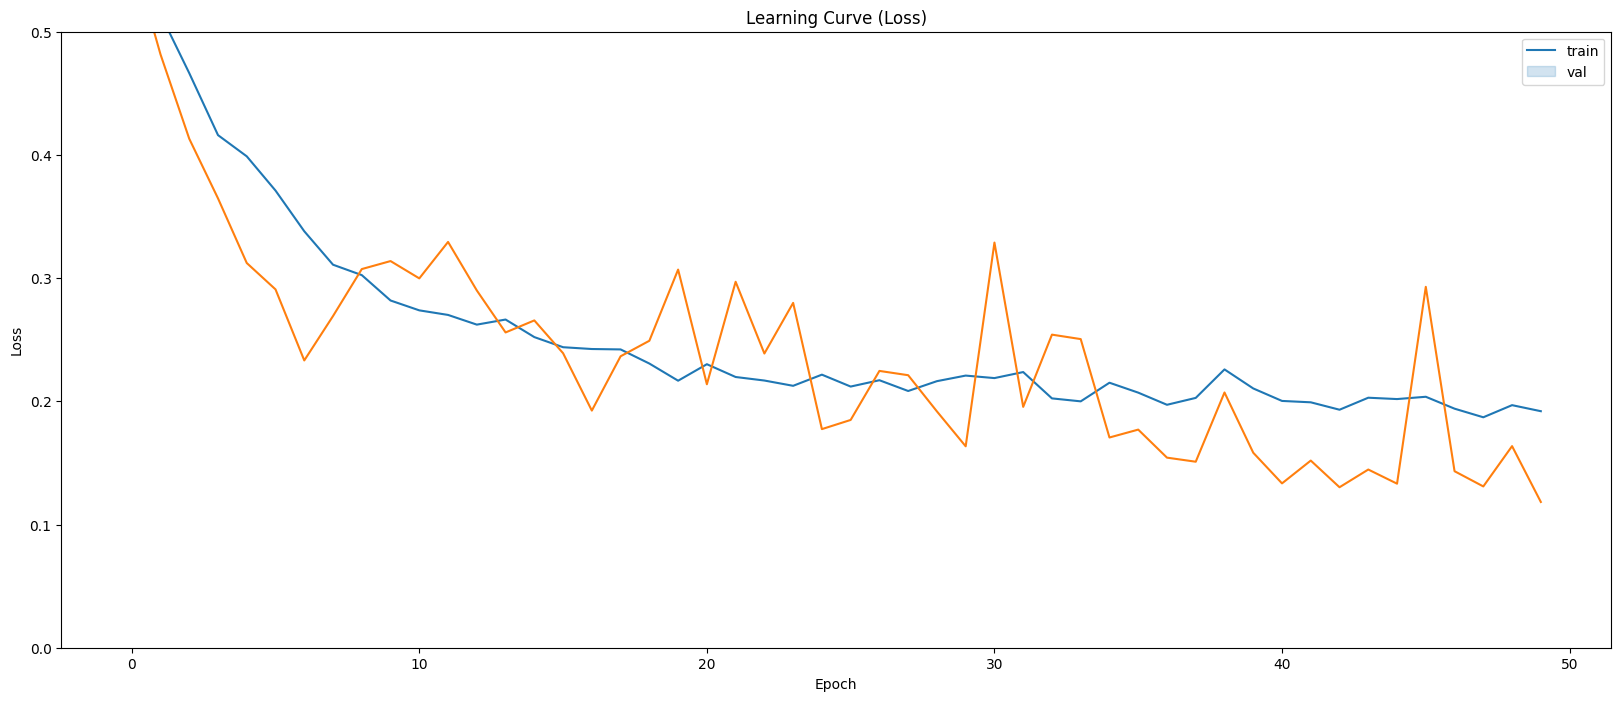

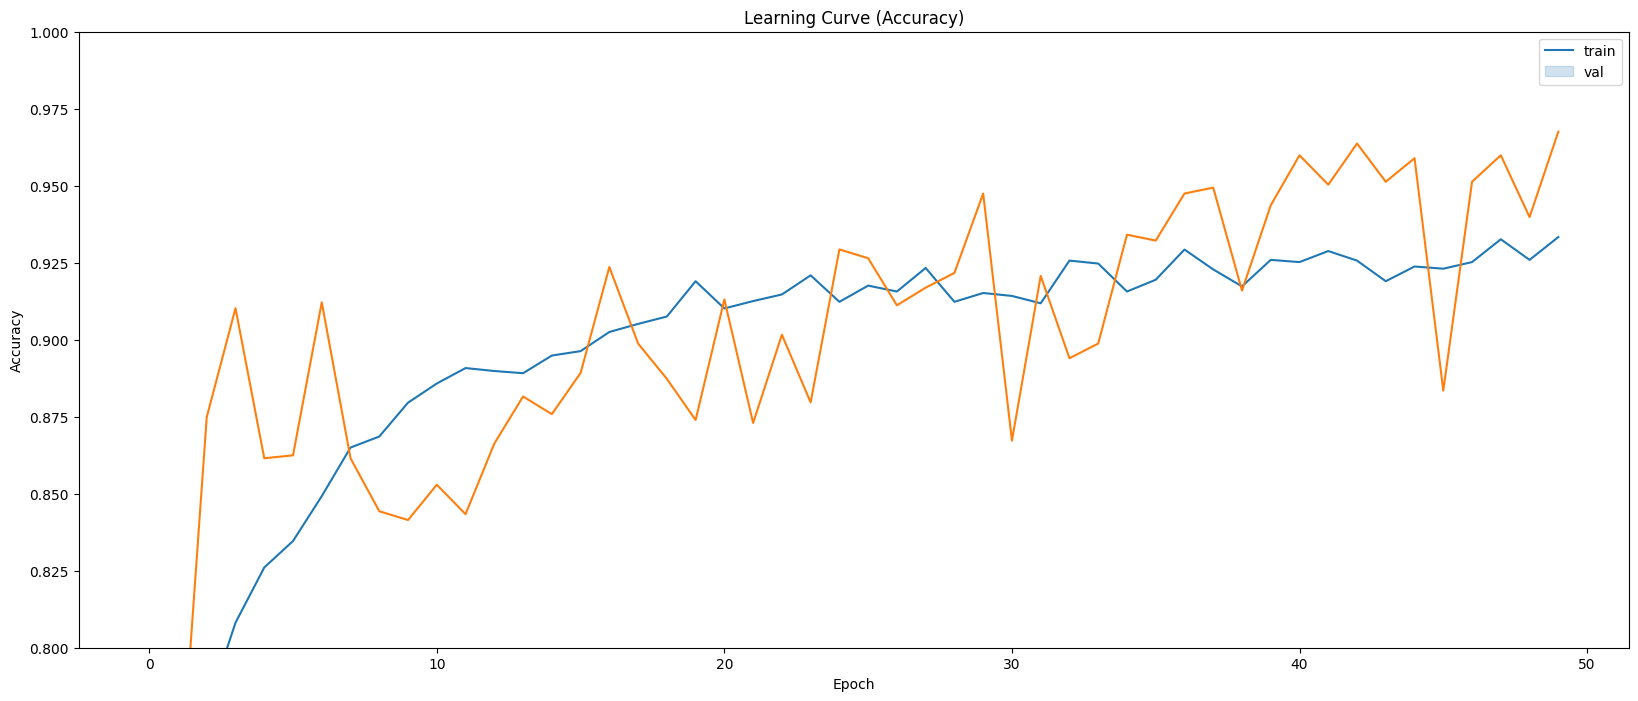

Val loss: 0.11830498278141022
Val accuracy: 0.9675262570381165
Test loss: 0.7948853969573975
Test accuracy: 0.800000011920929


In [18]:
# Plot learning curves
plot_learning_curves(history)

# Evaluate the model
evaluate_model(model1, ds_val, ds_test, val_steps=math.ceil(len(val_df) / BATCH), test_steps=math.ceil(len(df_test) / BATCH))

### Model 1 Analysis
**Accuracy:**
- The training accuracy improves consistently as the number of epochs increases, which is a good sign that the model is learning from the training data.
- The validation accuracy is more volatile and doesn't show a clear trend of improvement. This suggests the model might be overfitting the training data and is not generalizing as well on the unseen validation data.
- Towards the later epochs, there is no sign of convergence between training and validation accuracy, further indicating overfitting.

**Loss**
- The training loss decreases over time, which is expected as the model learns.
- The validation loss shows fluctuations and, in some cases, significant spikes. This is an indication that the model's predictions on the validation data vary in quality from epoch to epoch.

**Evaluation Metrics**
- Validation Loss: 0.1183 - This is relatively low, indicating that on average, the model's predictions are quite close to the true values on the validation set.
- Validation Accuracy: 96.75% - This is very high, suggesting that the model performs well on the validation data.

**Test Metrics**
- Test Loss: 0.7949 - The loss on the test set is significantly higher than on the validation set. This is a sign of poor generalization.
- Test Accuracy: 80.00% - There's a notable drop in accuracy compared to the validation accuracy, which further suggests that the model has not generalized well to the new data in the test set.

**Possible Improvements**
The model shows signs of overfitting, as evidenced by higher performance on the validation set compared to the test set, and by the erratic behavior of the validation metrics during training. We will be implementing a few improvements in the next iteration:

- Regularization: Increasing dropout or adding L1/L2 regularization whic might help prevent overfitting.
- Early Stopping: Stop the training when the validation loss starts to increase to prevent overfitting.
- Model Complexity: We will try to make the model a little more complex by adding a few more layers.
- Hyperparameter Tuning: Adjusting the learning rate which could lead to better generalization.

***

### Model 2

To start, we set up two callbacks for use during the training of a machine learning model in Keras for this Model:

- EarlyStopping: We will monitor the model's validation loss during training. If the validation loss doesn't show any significant improvement specifically, less than a very small threshold of 0.0000001 for 5 consecutive epochs (patience=5), the training process is stopped. This approach is effective in saving time and computational resources by stopping training when the model isn't learning anything new. Additionally, we include a helpful feature where we automatically restore the model's weights to those that achieved the best monitored performance. This means that even if the model's performance started to degrade in the last few epochs before stopping, we won't lose the best state of the model achieved during training.
 

- ReduceLROnPlateau: Here we will be fine tuning the model by adjusting the learning rate, which is pivotal in the convergence of the training algorithm. This callback continuously monitors the model's validation loss (monitor='val_loss') during training. If there’s no noticeable improvement marked by a change smaller than 0.0000001 (min_delt=1e-7) in this loss for 2 consecutive epochs (patience=2), the learning rate is reduced. The reduction is significant yet controlled, with the new learning rate set to 20% (factor=0.2) of its previous value. This strategy of reducing the learning rate helps in refining the model’s training by focusing on more precise adjustments, which can be particularly effective when the model appears to have reached a plateau in learning. Once the learning rate is decreased, there's no cooldown period (cooldown=0), so the learning rate can be altered again immediately in the subsequent epochs if needed. The verbose=1 setting ensures that these adjustments are reported, providing transparency into how the learning rate changes are influencing the model's training dynamics.

In [19]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,                                     
    patience=2,                                   
    min_delta=1e-7,                               
    cooldown=0,
    verbose=1
)


### Model 2 Architecture

The architecture of Model 2 shares similarities with Model 1, featuring an additional convolutional block. However, Model 2 incorporates early stopping and learning rate adjustments, enhancing its adaptability during training. With these additions, we anticipate improvements in both accuracy metrics and computational efficiency. The extra convolutional block enables the model to capture more intricate features from the data, potentially leading to enhanced performance. Additionally, the implementation of early stopping and learning rate adjustments optimizes the training process, ensuring the model converges efficiently while preventing overfitting. The first model has fewer total parameters compared to the second model due to its simpler architecture, allowing for faster training and reduced computational overhead. We believe that these architectural enhancements equip Model 2 with greater flexibility and effectiveness in handling image classification tasks.

In [20]:
def model2():
    
    # Define the input layer with the shape as [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One: First convolutional block
    # 1. Conv2D layer with 16 filters, a kernel size of 3, and valid padding
    # 2. Batch normalization to normalize the activations
    # 3. ReLU activation function
    # 4. Max pooling to reduce spatial dimensions
    # 5. Dropout for regularization with a rate of 20%
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two: Second convolutional block
    # Follows the same structure as Block One but with 32 filters
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three: Third convolutional block
    # 1. Two consecutive Conv2D layers with 64 filters each
    # 2. Followed by batch normalization, ReLU activation, max pooling, and dropout with a higher rate of 40%
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head of the model
    # 1. Flatten the output of the last convolutional block
    # 2. Dense layer with 64 neurons and ReLU activation
    # 3. Dropout with a rate of 50% for regularization
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Final Layer (Output)
    # Dense layer with a single neuron and sigmoid activation function for binary classification
    output = layers.Dense(1, activation='sigmoid')(x)
    
    # Creating the model instance with input and output specified
    model2 = keras.Model(inputs=[inputs], outputs=output)
    
    return model2

In [21]:
keras.backend.clear_session()

model2 = model2()
model2.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [22]:
# Train the model
history2 = model2.fit(
    ds_train,
    batch_size = BATCH,
    epochs=50,
    validation_data=ds_val,
    callbacks=[early_stopping, plateau],
    steps_per_epoch=math.ceil(len(train_df) / BATCH),
    validation_steps=math.ceil(len(val_df) / BATCH)
)

Epoch 1/50
131/131 [==============================] - 245s 2s/step - loss: 0.5368 - binary_accuracy: 0.7615 - val_loss: 0.6687 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 2/50
131/131 [==============================] - 950s 7s/step - loss: 0.3319 - binary_accuracy: 0.8461 - val_loss: 1.1227 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 3/50
131/131 [==============================] - ETA: 0s - loss: 0.2986 - binary_accuracy: 0.8748
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
131/131 [==============================] - 51s 387ms/step - loss: 0.2986 - binary_accuracy: 0.8748 - val_loss: 0.9444 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 4/50
131/131 [==============================] - 50s 382ms/step - loss: 0.2458 - binary_accuracy: 0.9025 - val_loss: 0.5673 - val_binary_accuracy: 0.7459 - lr: 6.0000e-06
Epoch 5/50
131/131 [==============================] - 49s 369ms/step - loss: 0.2375 - binary_accuracy: 0.8982 - val_loss: 0.1976 - 

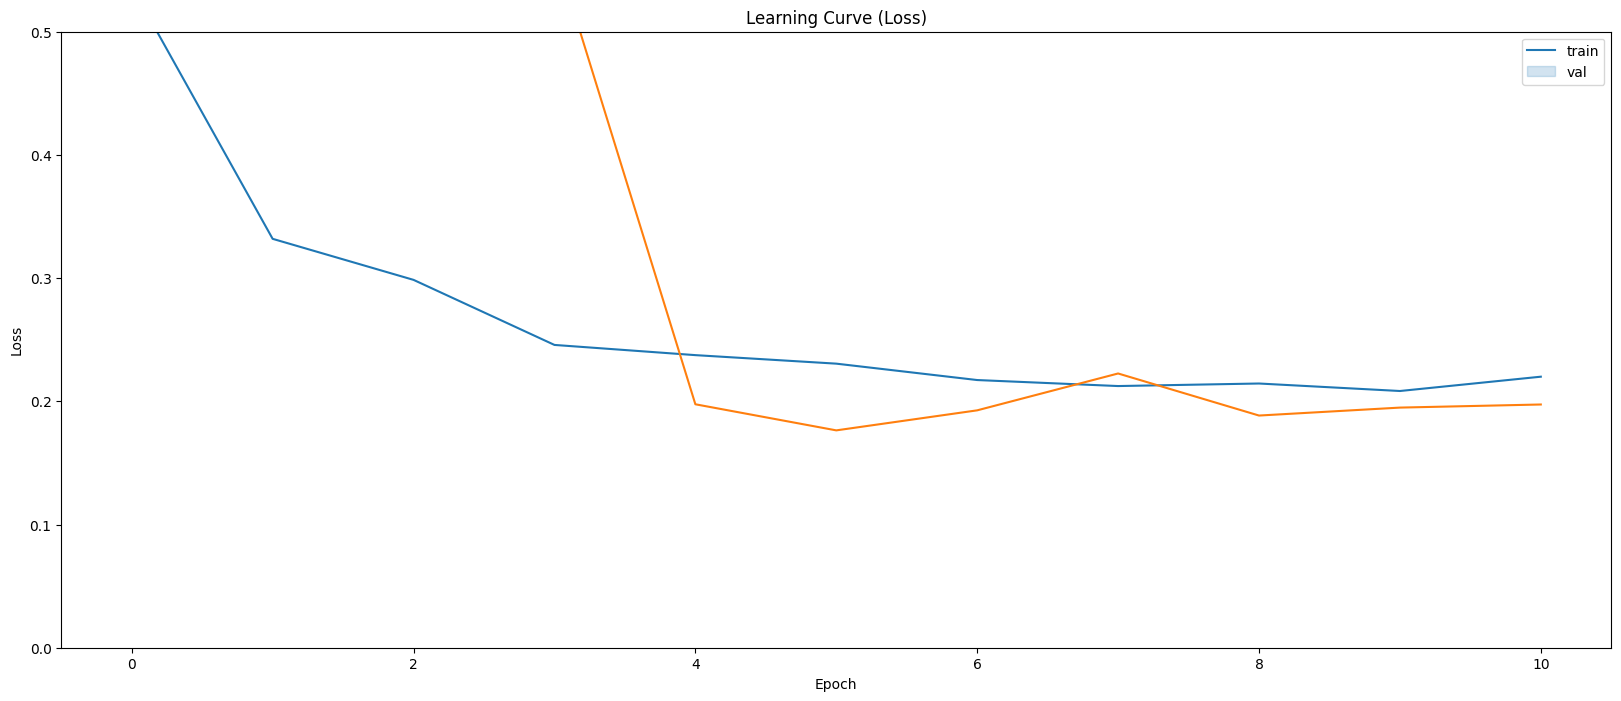

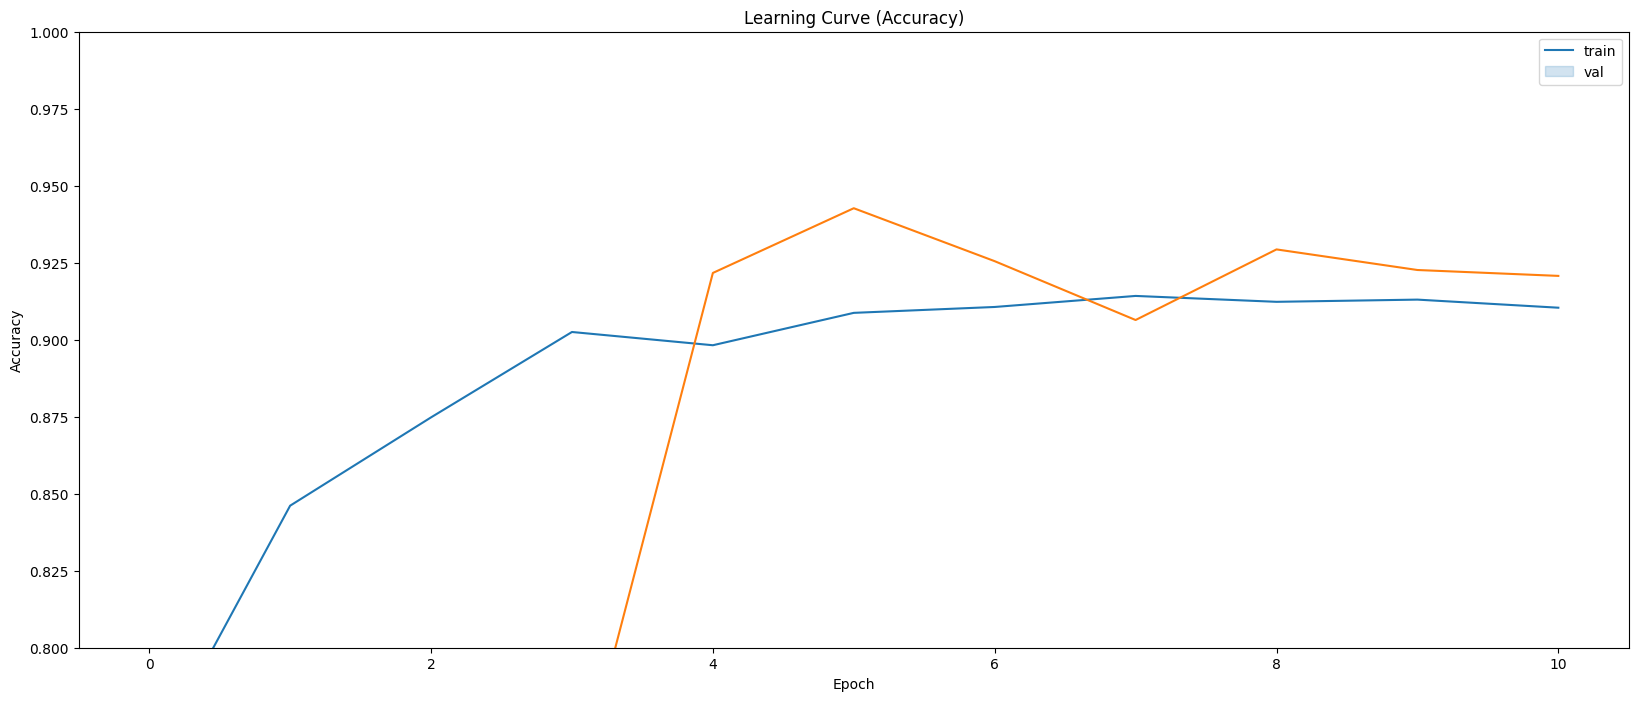

Val loss: 0.17642061412334442
Val accuracy: 0.9426934123039246
Test loss: 0.38880008459091187
Test accuracy: 0.8999999761581421


In [23]:
# Plot learning curves
plot_learning_curves(history2)

# Evaluate the model
evaluate_model(model2, ds_val, ds_test, val_steps=math.ceil(len(val_df) / BATCH), test_steps=math.ceil(len(df_test) / BATCH))

### Analysis of Model 2 and Comparison to Model 1

**Loss**
- The training loss for model2 decreases sharply and then somewhat stabilizes, which is a typical and healthy sign of learning.
- The validation loss decreases and then levels off, staying consistently low and closely following the training loss. This indicates that model2 is generalizing well without overfitting.

**Accuracy**
- The training accuracy increases quickly and then stabilizes, hovering around 90%.
- The validation accuracy for model2 also increases quickly and remains high and stable, mirroring the training accuracy closely. This suggests that model2 is performing well on unseen data.

**Model 2 Metrics**
- Validation Loss: 0.1764 - Slightly higher than model1, but still low.
- Validation Accuracy: 94.26% - A bit lower than model1, but still very high.
- Test Loss: 0.388 - Lower than model1, suggesting better generalization to the test data.
- Test Accuracy: 89.99% - Higher than model1, indicating a better performance on the test set.

**Comparison Between Model 1 and Model 2**
- Overfitting: model1 shows signs of overfitting as there is a significant gap between the training and validation metrics. The learning curves for model2 suggest less overfitting, as indicated by the more parallel nature of the training and validation lines.
- Stability: The learning curves of model2 are less volatile, especially in terms of validation loss and accuracy, suggesting that model2 is more stable during training.
- Test Performance: While model1 has a slightly better validation accuracy, model2 outperforms model1 on the test set in terms of both loss and accuracy.

Model2 seems to strike a better balance between learning from the training data and generalizing to new data. This is reflected in the higher test accuracy and lower test loss compared to model1. The learning curves and final evaluation suggest that model2 may be a better model overall, particularly for new unseen data.

Next we will use the histogram_equalization images with model 2 and compare results

### Model 2 with histogram equalization images

In [30]:
history2_he = model2.fit(
    ds_train_he,  # Using the histogram equalization training data
    epochs=50,
    validation_data=ds_val_he,  # Using the histogram equalization validation data
    callbacks=[early_stopping, plateau],
    steps_per_epoch=math.ceil(len(train_df) / BATCH),  
    validation_steps=math.ceil(len(val_df) / BATCH)  
)

Epoch 1/50
131/131 [==============================] - 56s 423ms/step - loss: 0.3418 - binary_accuracy: 0.8552 - val_loss: 0.4542 - val_binary_accuracy: 0.7631 - lr: 2.4000e-07
Epoch 2/50
131/131 [==============================] - 58s 441ms/step - loss: 0.3086 - binary_accuracy: 0.8633 - val_loss: 0.3620 - val_binary_accuracy: 0.8195 - lr: 2.4000e-07
Epoch 3/50
131/131 [==============================] - 55s 419ms/step - loss: 0.3104 - binary_accuracy: 0.8667 - val_loss: 0.3385 - val_binary_accuracy: 0.8338 - lr: 2.4000e-07
Epoch 4/50
131/131 [==============================] - 57s 435ms/step - loss: 0.2964 - binary_accuracy: 0.8628 - val_loss: 0.3301 - val_binary_accuracy: 0.8386 - lr: 2.4000e-07
Epoch 5/50
131/131 [==============================] - 58s 437ms/step - loss: 0.2960 - binary_accuracy: 0.8686 - val_loss: 0.3264 - val_binary_accuracy: 0.8424 - lr: 2.4000e-07
Epoch 6/50
131/131 [==============================] - 58s 439ms/step - loss: 0.3049 - binary_accuracy: 0.8679 - val_loss

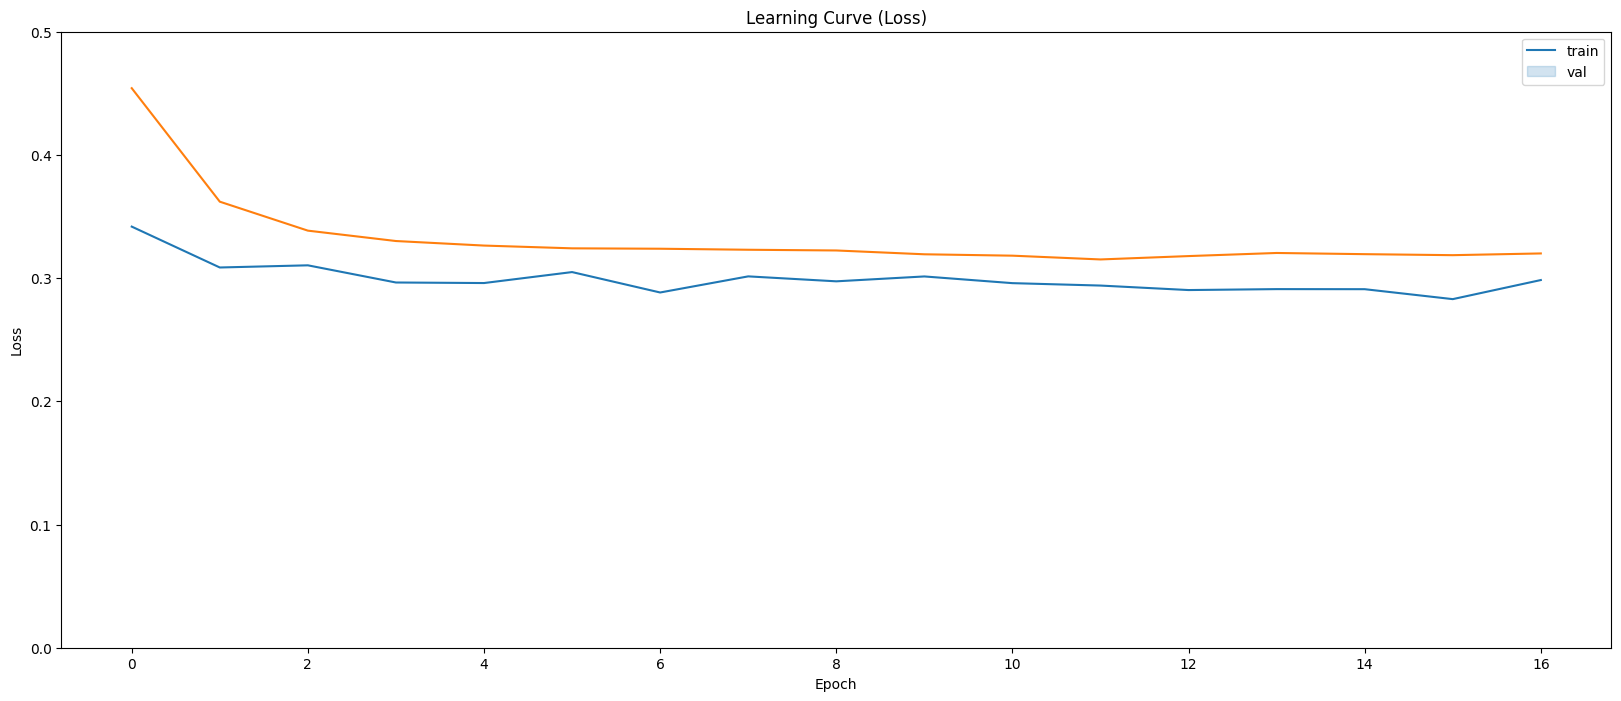

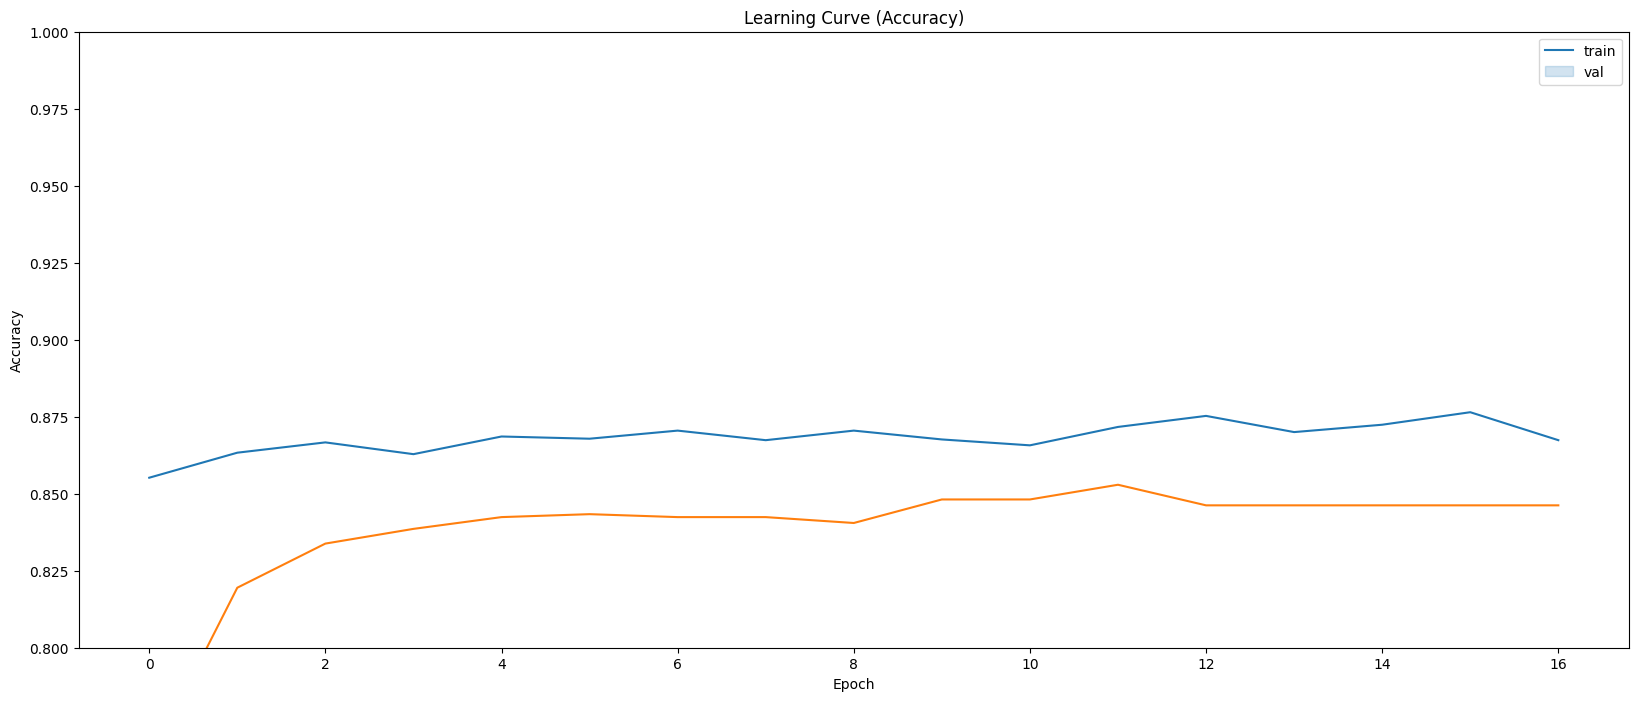

Val loss: 0.3151606321334839
Val accuracy: 0.8529130816459656
Test loss: 0.3800372779369354
Test accuracy: 0.8500000238418579


In [31]:
# Plot learning curves
plot_learning_curves(history2_he)

# Evaluate the model
evaluate_model(model2, ds_val_he, ds_test_he, val_steps=math.ceil(len(val_df_he) / BATCH), test_steps=math.ceil(len(df_test_he) / BATCH))

### Model 2 vs Model 2 with histogram equalization analysis

-   **Validation Loss:** Model 2 has a lower validation loss than Model 3, indicating it performed better on the validation set.
-   **Validation Accuracy:** Model 2 also has a higher validation accuracy than Model 3.
-   **Test Loss:** Model 2 has a higher test loss than Model 3, which could indicate overfitting since it performs well on the validation set but worse on the test set.
-   **Test Accuracy:** Consistent with the test loss, Model 2 has a higher test accuracy than Model 3. Despite the higher test loss, it correctly classified more instances in the test set.

From these metrics, Model 2 seems to have learned better, achieving higher accuracy and lower loss on the validation set. However, the test loss being higher than that of Model 3 while still having higher accuracy suggests that Model 2 could be overfitting to the validation set but still generalizing somewhat better than Model 3 on the test set.

The learning curves support this interpretation:

-   For Model 2 the loss decreases quickly and then flattens out, indicating rapid learning followed by stabilization. The accuracy curve shows a quick increase and then remains stable.
-   For Model 3, both the loss and accuracy curves are more gradual and closer together for training and validation, which suggests less overfitting but also less effective learning overall.
-   The application of histogram equalization in Model 3 doesn't seem to have improved the model's performance compared to Model 2. So histogram equalization does not benefit the specific data or this problem. 

With that said we would recommend using model 2. Next we will discuss some of the performance metrics.

### Model 2 performance metrics and conclusions

Test Accuracy:  0.8910256410256411


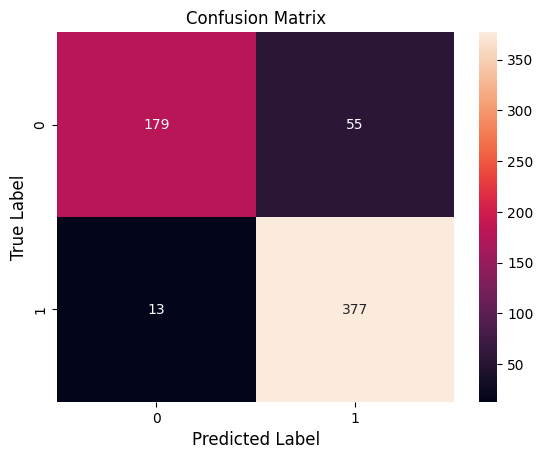

              precision    recall  f1-score   support

           0       0.93      0.76      0.84       234
           1       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624

ROC_AUC:  0.9718387026079334


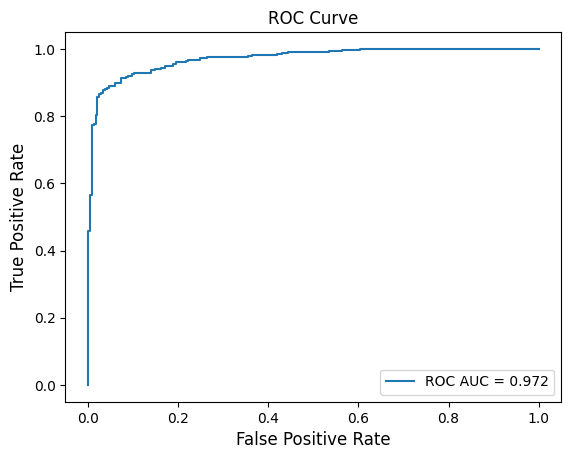

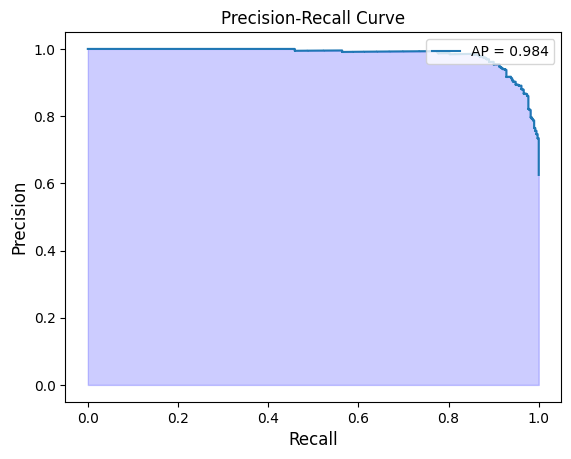

In [27]:
# Map textual class labels to numerical labels (0 and 1)
num_label = {'Normal': 0, 'Pneumonia': 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

# Reset the test dataset generator before making predictions
ds_test.reset()

# Generate predictions for the test dataset
predictions = model2.predict(ds_test, steps=len(ds_test), verbose=0)

# Convert prediction probabilities to binary labels with a 0.5 threshold
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Calculate and print the accuracy of the model on the test set
test_accuracy = accuracy_score(Y_test, predicted_labels)
print("Test Accuracy: ", test_accuracy)

# Compute the confusion matrix and plot it as a heatmap
conf_mat = confusion_matrix(Y_test, predicted_labels)
sns.heatmap(conf_mat, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()

# Generate and print a classification report detailing precision, recall, and F1-score
class_report = classification_report(Y_test, predicted_labels, labels=[0, 1])
print(class_report)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

# Compute the ROC curve points
fpr, tpr, _ = roc_curve(Y_test, predictions)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.title('ROC Curve')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.show()

# Calculate Precision-Recall curve and Average Precision (AP) score
precision, recall, _ = precision_recall_curve(Y_test, predictions)
average_precision = average_precision_score(Y_test, predictions)

# Plot the Precision-Recall curve
plt.step(recall, precision, where='post', label=f'AP = {average_precision:.3f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.legend(loc='upper right')
plt.show()


Based on the results and the provided graphs, we can draw the following conclusions about the model's performance:

- Test Accuracy: The model achieves an overall test accuracy of approximately 89.10%, which indicates that it is quite effective at classifying the test data correctly.

- Confusion Matrix: The confusion matrix shows that the model has more false negatives (55 cases where Pneumonia is not detected when it is present) compared to false positives (13 cases where Normal is classified as Pneumonia). This suggests that the model is more conservative in predicting the Pneumonia class, it's more likely to miss cases of Pneumonia than to falsely alarm them.

- Classification Report: The model has high precision for class '0' (Normal), which means that when it predicts Normal, it is correct about 93% of the time.
The recall for class '0' is lower at 76%, meaning it misses around 24% of the actual Normal cases.
Class '1' (Pneumonia) has high recall (97%), indicating the model is very effective at identifying most of the positive cases for Pneumonia.
Precision for class '1' is slightly lower at 87%, indicating there are some false positives, but it's still relatively high.
The F1-score, which balances precision and recall, is high for both classes, particularly for class '1'.

- ROC Curve and AUC: The ROC AUC score is 0.972, which is very close to 1, indicating that the model has an excellent measure of separability. It means that the model has a high true positive rate and a low false positive rate across different threshold settings.

- Precision-Recall Curve and AP: The Average Precision (AP) score is 0.984, showing that the model maintains a high precision across different levels of recall. The Precision-Recall curve also shows a high area under the curve, which is ideal.

- Possible Improvements: Despite the good performance, there may still be room for improvement, particularly in reducing the number of false negatives given the medical nature of the task. Techniques such as further data augmentation, more advanced model architectures, or transfer learning

## Conclusion
Model 2 performs well, with high accuracy, excellent ROC AUC, and AP scores. However, considering the false negatives and the potential consequences in a real world setting, further tuning and validation might be needed to ensure its reliability for clinical use.